# Ping pong result simulator
#### By: Magnus Kvåle Helliesen
It seems that the result *(9,6)* or *(6,9)* pops up in ping pong unreasonably often. This notebook simulates ping pong matches to see how often it should in fact pop up.

In [105]:
import random
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np

We make a funciton that returns the result from a single exchange between two players, player 0 and player 1, where $P(\textrm{player 0 wins})=p_0$. The simulation is performed using a uniformily distributet variable $x\sim U(0,1)$, and player 0 wins if $x\leq p_0$. The function returns a pair of values: *person 0 won*, *person 1 won* (boolean values).

In [106]:
def result_from_single_exchange(p0):
    random_uniform = random.uniform(0,1)
    return (random_uniform <= p0), (random_uniform > p0)

Next, we make a function that simulates a whole game, that is a sequence of exchanges until the criteriea for having won the game are met (score is at least 11, and difference in score is at least 2). The function returns a list of all the scores of the game, that is a list of tuples of *(points player 0, points player 1)*.

In [107]:
def result_from_game(p0):
    scores_in_game = [(0, 0)]
    while (max(scores_in_game[-1][0], scores_in_game[-1][1]) < 11) or (abs(scores_in_game[-1][0]-scores_in_game[-1][1]) < 2):
        player0_won, player1_won = result_from_single_exchange(p0)
        scores_in_game.append((scores_in_game[-1][0]+player0_won, scores_in_game[-1][1]+player1_won))
    return scores_in_game

Lets look at an example game between two equally good players, i.e. $p_0 = 1/2$.

In [108]:
# An example game between equally good players
example_game = result_from_game(0.5)

In [119]:
# All scores of the game
print(*example_game)

(0, 0) (1, 0) (1, 1) (1, 2) (1, 3) (2, 3) (2, 4) (2, 5) (2, 6) (3, 6) (4, 6) (4, 7) (4, 8) (5, 8) (6, 8) (7, 8) (8, 8) (9, 8) (9, 9) (9, 10) (9, 11)


In [110]:
# The game ended with the score
example_game[-1]

(9, 11)

We generate a function that simulates $n$ games and stores all the results to a list. (We will be able to distinguish between games later because every game starts with *(0,0)*.)

In [111]:
def game_simulator(p0, n, seed):
    random.seed(seed)
    simulation_of_games = []
    for i in range(n):
        simulation_of_games.extend(result_from_game(p0))
    return simulation_of_games

We now simulate 100,000 games and store it to a list. We then put it in a DataFrame, manipulate it, and plot it as a heatmap. We see that scores along the diagonal (that is, farily even matches) are happen most frequently. Sometimes on player wins 11 to nothing, and sometimes they play until 25 and more.

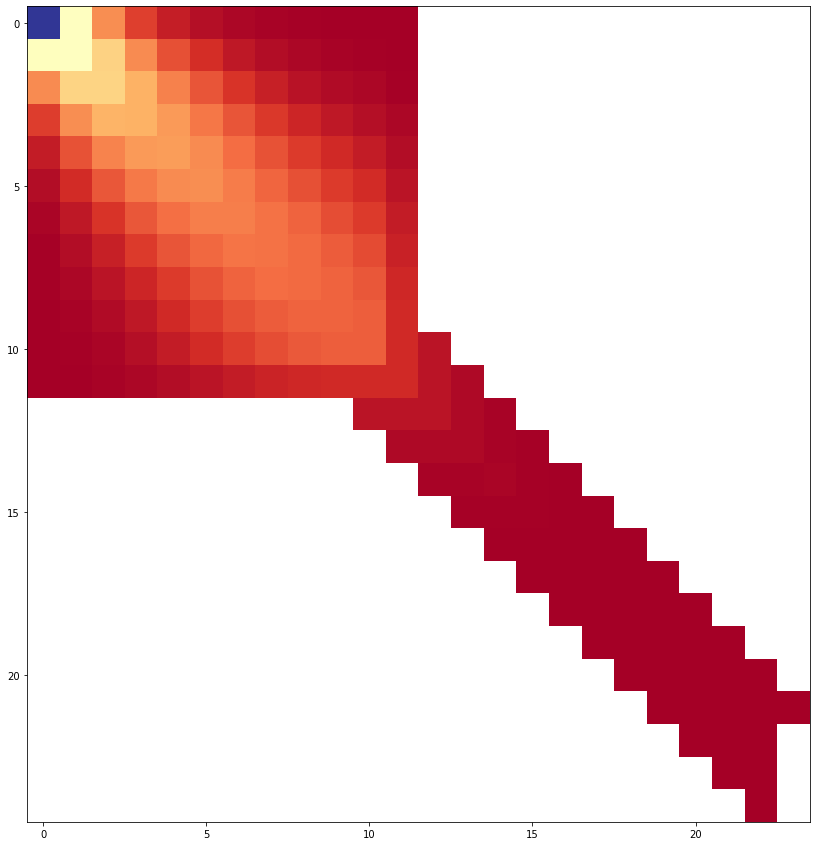

In [123]:
simulation_of_games = game_simulator(0.5, 100000, 1234)

df = pd.DataFrame(simulation_of_games, columns=['player0_wins', 'player1_wins'])

df_to_plot = (
    pd.DataFrame(simulation_of_games, columns=['player0_wins', 'player1_wins'])
    .assign(**{'': 1})
    .groupby(['player0_wins', 'player1_wins'])
    .count()
    .reset_index()
    .pivot_table(index=['player0_wins'], columns=['player1_wins'])
)

plt.figure(figsize=(15,15))
plt.imshow(df_to_plot, cmap ="RdYlBu")
plt.show()

We also calculate the simulated probability of having the score result *(9,6)* or *(6,9)* in any given match. We see that it's about 30 %.

In [113]:
df = df.assign(**{'new_match': lambda df: [1 if (p1, p2) == (0, 0) else 0 for p1, p2 in zip(df['player0_wins'], df['player1_wins'])]})
df = df.assign(**{'match_id': lambda df: df['new_match'].cumsum()})
df = df.assign(**{'96/69': lambda df: [1 if (p1, p2) in ((9, 6), (6, 9)) else 0 for p1, p2 in zip(df['player0_wins'], df['player1_wins'])]})
df.groupby(df['match_id'])['96/69'].sum().mean()

0.30518

## Plots of scores for differen $P_0$
We now make a function that makes neat subplots for different relative skill levels.

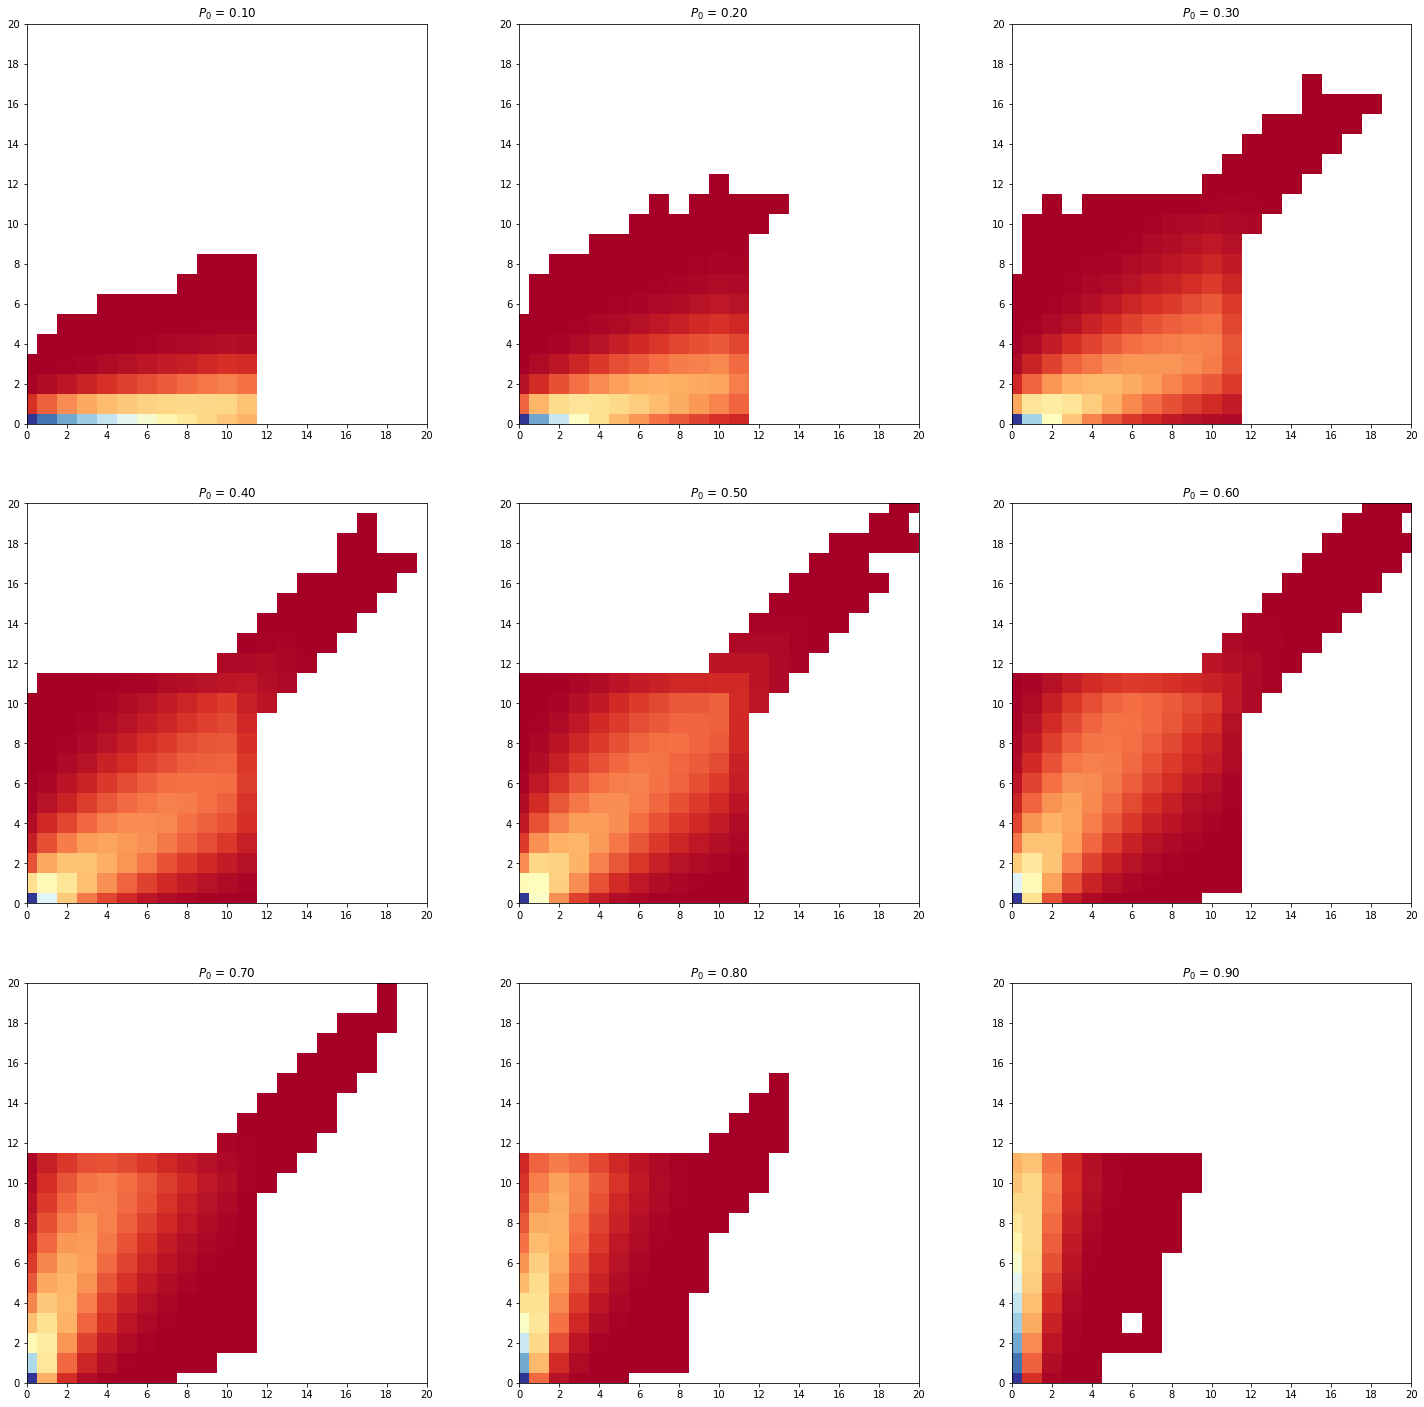

In [121]:
def result_creator(n, seed):
    fig, ax = plt.subplots(3, 3, figsize=(25, 25))
    i, j = 0, 0
    for p0 in np.arange(0, 1, 0.1)[1:]:
        simulation_of_games = game_simulator(p0, n, 1234)

        df = pd.DataFrame(simulation_of_games, columns=['player0_wins', 'player1_wins'])

        df_to_plot = (
            pd.DataFrame(simulation_of_games, columns=['player0_wins', 'player1_wins'])
            .assign(**{'': 1})
            .groupby(['player0_wins', 'player1_wins'])
            .count()
            .reset_index()
            .pivot_table(index=['player0_wins'], columns=['player1_wins'])
        )

        ax[j ,i].imshow(df_to_plot, cmap ="RdYlBu")
        ax[j ,i].title.set_text(''.join(['$P_0$ = ','{0:.2f}'.format(p0)]))
        ax[j ,i].set_xlim((0, 20))
        ax[j ,i].set_ylim((0, 20))
        ax[j ,i].yaxis.set_major_locator(MaxNLocator(integer=True))
        ax[j ,i].xaxis.set_major_locator(MaxNLocator(integer=True))
        
        if i == 2:
            i = 0
            j += 1
        else:
            i += 1

In [ ]:
result_creator(100000, 1234)